## Load modules

In [128]:
import glob
from pathlib import Path
import os, sys
import copy
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

import pandas as pd
from PIL import Image

import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

from qgm import evaluation
plt.style.use("default")

from scipy import optimize
import scipy.optimize

## Load images

In [129]:
date = '20211208'
dataNo = 2
scanNo = 2

In [130]:
path = os.getcwd()  +'\\'+ date
# path = r"./"+date
path_img = path + "\\data" + str('%03d' % dataNo) + "\\raw"
path_scan = path + "\\scandir\\Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + "\\scandir\\Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [183]:
param_name = 'A0157: OL (H1): AM for physics 2'
scan_param =3.4/4*np.exp((scan_data[param_name]-5.03)/0.646)
unique_param = scan_param.unique()
total_count = scan_data["Total count1 @ ROI1 (arb. u.)"]

## Sample image

In [132]:
seq_no = 100

In [133]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No Data")

In [134]:
img1 = image.image(trans_files[seq_no])
img1.generate_bg_image(path_img +'\\seq00000_flat001.tiff', True)

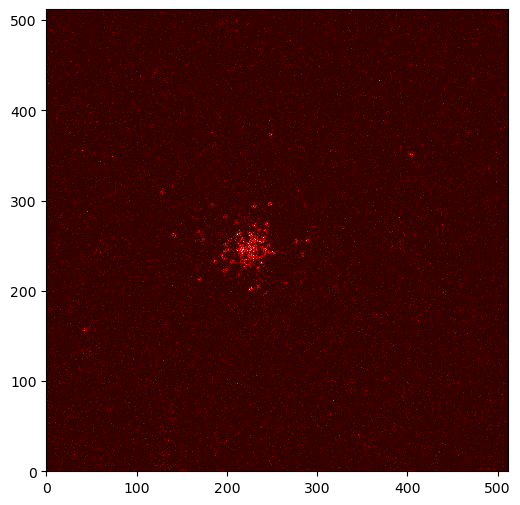

In [135]:
cmap = image.generate_cmap(['#330000', 'r', 'w'])
plt.figure(figsize=(6,6),dpi=100)
plt.subplot(111)
plt.pcolormesh(img1.image,cmap=cmap,vmin=0,vmax=np.max(img1.image)*0.8)
plt.gca().set_aspect('equal')

In [136]:
img1_x = np.sum(img1.image, axis=0)
img1_y = np.sum(img1.image, axis=1)

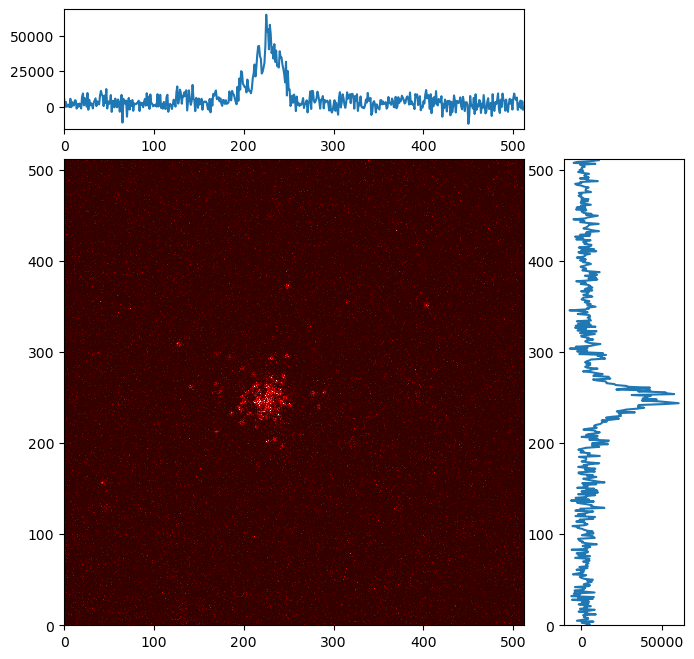

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(img1.image,cmap=cmap,vmin=0,vmax=np.max(img1.image)*0.8)
divider1 = make_axes_locatable(ax1)
ax1X = divider1.append_axes("top",1.2,pad=0.3,sharex=ax1)
ax1X.plot(img1_x)
ax1Y = divider1.append_axes("right",1.2,pad=0.4,sharey=ax1)
ax1Y.plot(img1_y,range(len(img1_y)))


In [138]:
img1_lowpass = copy.deepcopy(img1)
img1_lowpass.image, img_fft, (fx, fy), (FX, FY) = filter.lowpass(img1_lowpass, factor=0.6)


In [139]:
img1_lowpass_x = np.sum(img1_lowpass.image, axis=0)
img1_lowpass_y = np.sum(img1_lowpass.image, axis=1)

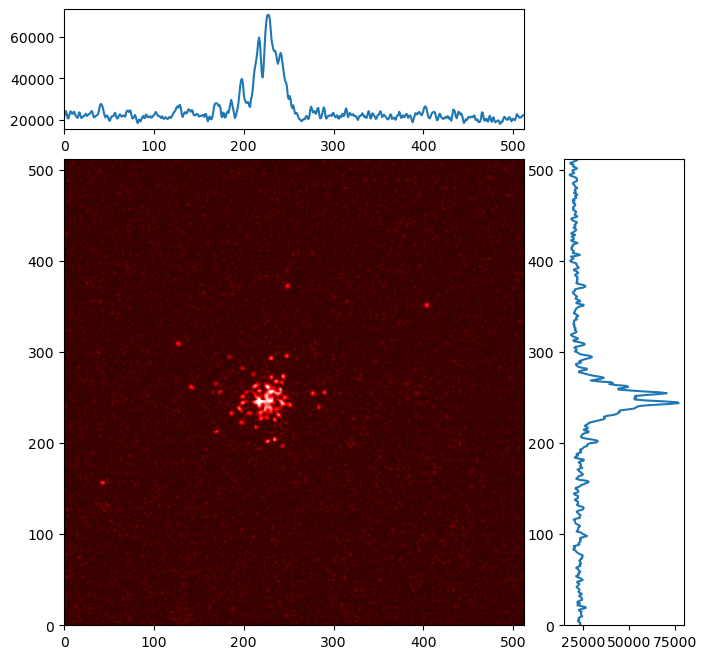

In [140]:
fig = plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(img1_lowpass.image,cmap=cmap,vmin=0,vmax=np.max(img1_lowpass.image)*0.8)
divider1 = make_axes_locatable(ax1)
ax1X = divider1.append_axes("top",1.2,pad=0.3,sharex=ax1)
ax1X.plot(img1_lowpass_x)
ax1Y = divider1.append_axes("right",1.2,pad=0.4,sharey=ax1)
ax1Y.plot(img1_lowpass_y,range(len(img1_lowpass_y)))

## Fitting

In [141]:
CoMx = []
CoMy = []
for i in range(len(img1_x)):
    CoMx += [i*img1_x[i]/np.sum(img1_x)]
for i in range(len(img1_y)):
    CoMy += [i*img1_y[i]/np.sum(img1_y)]

CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)
print(CoMx)
print(CoMy)

Sigx = []
Sigy = []
for i in range(len(img1_x)):
    Sigx += [(i-CoMx)**2*img1_x[i]**2/np.sum(img1_x**2)]
for i in range(len(img1_y)):
    Sigy += [(i-CoMy)**2*img1_y[i]**2/np.sum(img1_y**2)]

Sigx = np.sqrt(np.sum(Sigx))
Sigy = np.sqrt(np.sum(Sigy))
print(Sigx)
print(Sigy)

233.62111818284262
252.10716204717647
63.68974607230969
56.62187289835206


In [142]:
para_ini_x = [np.max(img1_x)-np.min(img1_x),CoMx,Sigx,0]
para_ini_y = [np.max(img1_y)-np.min(img1_y),CoMy,Sigy,0]

def nonlinear_fit(x,a,b,c,d):
    return a*np.exp(-(x-b)**2/(2*c**2))+d

param_x, cov_x = scipy.optimize.curve_fit(nonlinear_fit,range(len(img1_x)),img1_x,para_ini_x)
param_y, cov_y = scipy.optimize.curve_fit(nonlinear_fit,range(len(img1_y)),img1_y,para_ini_y)

img1_fit_x =[]
img1_fit_y =[]

for num in range(len(img1_x)):
    img1_fit_x.append(param_x[0]*np.exp(-(num-param_x[1])**2/(2*param_x[2]**2))+param_x[3])
for num in range(len(img1_y)):
    img1_fit_y.append(param_y[0]*np.exp(-(num-param_y[1])**2/(2*param_y[2]**2))+param_y[3])

perr_x = np.sqrt(np.diag(cov_x))
perr_y = np.sqrt(np.diag(cov_y))
print("ax=", str(param_x[0]))
print("ax_err=", str(perr_x[0]))
print("bx=", str(param_x[1]))
print("bx_err=", str(perr_x[1]))
print("cx=", str(param_x[2]))
print("cx_err=", str(perr_x[2]))

print("ay=", str(param_y[0]))
print("ay_err=", str(perr_y[0]))
print("by=", str(param_y[1]))
print("by_err=", str(perr_y[1]))
print("cy=", str(param_y[2]))
print("cy_err=", str(perr_y[2]))



ax= 40924.62181463026
ax_err= 1181.7152380625985
bx= 227.3735911794387
bx_err= 0.46948796912645213
cx= 14.21496213055861
cx_err= 0.4828507312742396
ay= 42709.78746954313
ay_err= 1099.9869389288167
by= 247.970835404435
by_err= 0.4101927548640352
cy= 13.921225405854933
cy_err= 0.4215896286383915


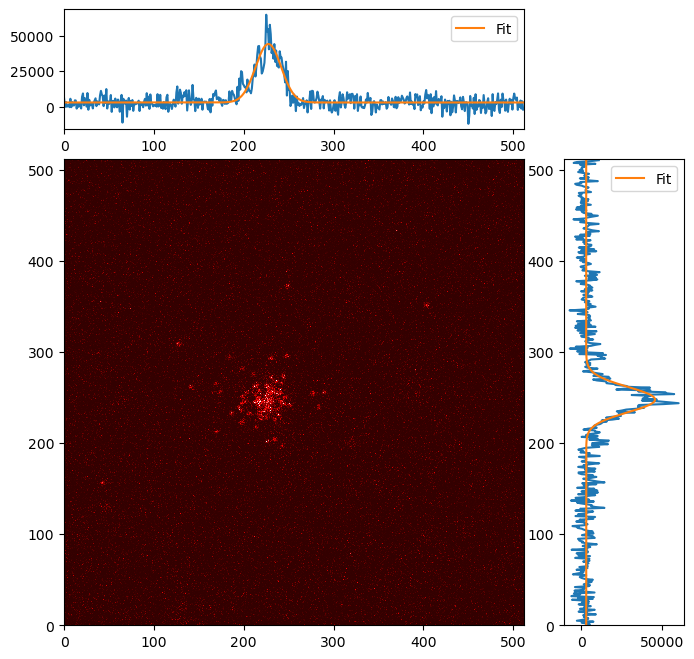

In [143]:
fig = plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(img1.image,cmap=cmap,vmin=0,vmax=np.max(img1.image)*0.8)
divider1 = make_axes_locatable(ax1)
ax1X = divider1.append_axes("top",1.2,pad=0.3,sharex=ax1)
ax1X.plot(img1_x)
ax1X.plot(img1_fit_x,label="Fit")
ax1X.legend()
ax1Y = divider1.append_axes("right",1.2,pad=0.4,sharey=ax1)
ax1Y.plot(img1_y,range(len(img1_y)))
ax1Y.plot(img1_fit_y,range(len(img1_y)),label="Fit")
ax1Y.legend()

## Measure Cloud centers and widths

In [154]:
sigx_list = []
sigy_list = []
cx_list = []
cy_list = []

for s in range(len(trans_files)):
    #load an image
    img1 = image.image(trans_files[s])
    img1.generate_bg_image(path_img +'\\seq00000_flat001.tiff', True)
    
    img1_x = np.sum(img1.image, axis=0)
    img1_y = np.sum(img1.image, axis=1)
    
    #Roughly calculate centers and withds to use as initial values
    CoMx = []
    CoMy = []
    for i in range(len(img1_x)):
        CoMx += [i*img1_x[i]/np.sum(img1_x)]
    for i in range(len(img1_y)):
        CoMy += [i*img1_y[i]/np.sum(img1_y)]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    Sigx = []
    Sigy = []
    for i in range(len(img1_x)):
        Sigx += [(i-CoMx)**2*img1_x[i]**2/np.sum(img1_x**2)]
    for i in range(len(img1_y)):
        Sigy += [(i-CoMy)**2*img1_y[i]**2/np.sum(img1_y**2)]
    Sigx = np.sqrt(np.sum(Sigx))
    Sigy = np.sqrt(np.sum(Sigy))

    #Fitting
    para_ini_x = [np.max(img1_x)-np.min(img1_x),CoMx,Sigx,0]
    para_ini_y = [np.max(img1_y)-np.min(img1_y),CoMy,Sigy,0]
    param_x, cov_x = scipy.optimize.curve_fit(nonlinear_fit,range(len(img1_x)),img1_x,para_ini_x)
    param_y, cov_y = scipy.optimize.curve_fit(nonlinear_fit,range(len(img1_y)),img1_y,para_ini_y)
    # img1_fit_x =[]
    # img1_fit_y =[]
    # for num in range(len(img1_x)):
    #     img1_fit_x.append(param_x[0]*np.exp(-(num-param_x[1])**2/(2*param_x[2]**2))+param_x[3])
    # for num in range(len(img1_y)):
    #     img1_fit_y.append(param_y[0]*np.exp(-(num-param_y[1])**2/(2*param_y[2]**2))+param_y[3])
    cx_list.append(param_x[1])
    cy_list.append(param_y[1])
    sigx_list.append(np.abs(param_x[2]))
    sigy_list.append(np.abs(param_y[2]))


No handles with labels found to put in legend.


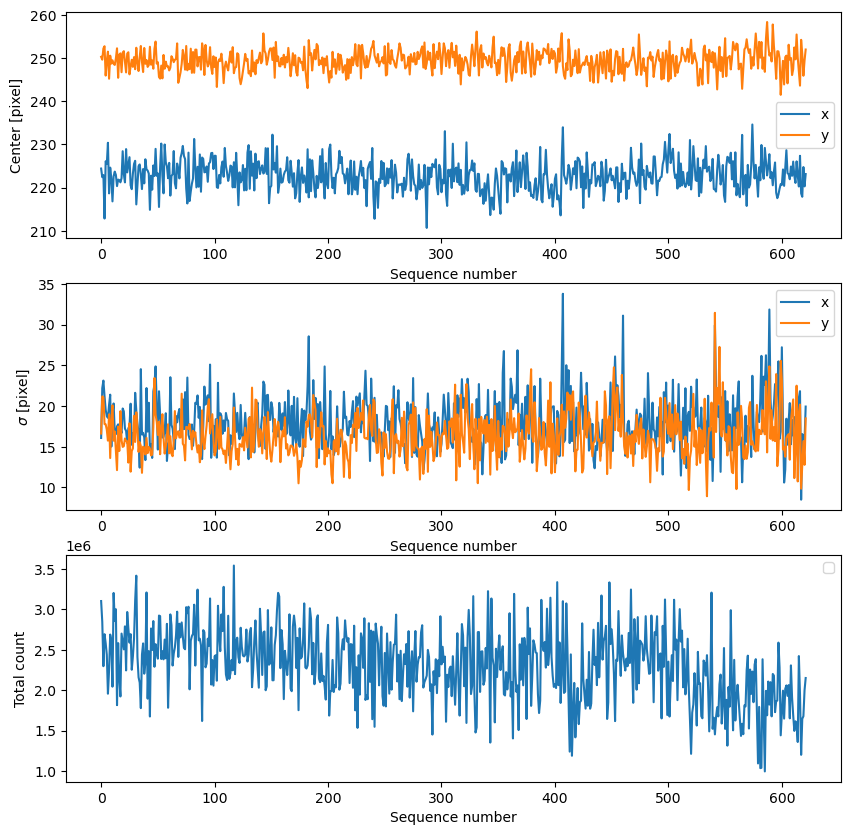

In [186]:
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(3,1,1)
ax1.plot(cx_list, label="x")
ax1.plot(cy_list, label="y")
ax1.set_ylabel("Center [pixel]")
ax1.set_xlabel("Sequence number")
ax1.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(sigx_list, label="x")
ax2.plot(sigy_list, label="y")
ax2.set_ylabel(r"$\sigma$ [pixel]")
ax2.set_xlabel("Sequence number")
ax2.legend()

ax3 = fig.add_subplot(3,1,3)
ax3.plot(total_count)
ax3.set_ylabel("Total count")
ax3.set_xlabel("Sequence number")
ax3.legend()

In [187]:
cx_2_list = []
cx_2_err_list = []
cy_2_list = []
cy_2_err_list = []
sigx_2_list = []
sigx_2_err_list = []
sigy_2_list = []
sigy_2_err_list = []
total_count_list = []
total_count_err_list = []

for i in range(len(unique_param)):
    cx_2_temp = []
    cy_2_temp = []
    sigx_2_temp = []
    sigy_2_temp = []
    total_count_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            cx_2_temp.append(cx_list[j])
            cy_2_temp.append(cy_list[j])
            sigx_2_temp.append(sigx_list[j])
            sigy_2_temp.append(sigy_list[j])
            total_count_temp.append(total_count[j])

    cx_2_list.append(np.mean(cx_2_temp))
    cx_2_err_list.append(np.std(cx_2_temp))
    cy_2_list.append(np.mean(cy_2_temp))
    cy_2_err_list.append(np.std(cy_2_temp))
    sigx_2_list.append(np.mean(sigx_2_temp))
    sigx_2_err_list.append(np.std(sigx_2_temp))
    sigy_2_list.append(np.mean(sigy_2_temp))
    sigy_2_err_list.append(np.std(sigy_2_temp))
    total_count_list.append(np.mean(total_count_temp))
    total_count_err_list.append(np.std(total_count_temp))


Text(0.5, 0, 'Potential depth [$E_R^{\\lambda}$]')

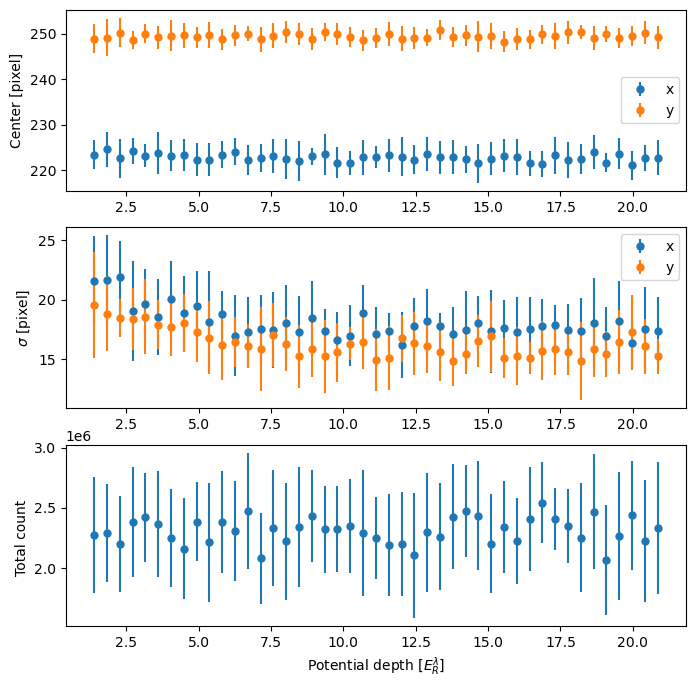

In [189]:
fig = plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(3,1,1)
ax1.errorbar(unique_param,cx_2_list,cx_2_err_list,fmt='o',markersize=5,label='x')
ax1.errorbar(unique_param,cy_2_list,cy_2_err_list,fmt='o',markersize=5,label='y')
ax1.set_ylabel("Center [pixel]")
ax1.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.errorbar(unique_param,sigx_2_list,sigx_2_err_list,fmt='o',markersize=5,label='x')
ax2.errorbar(unique_param,sigy_2_list,sigy_2_err_list,fmt='o',markersize=5,label='y')
ax2.set_ylabel(r"$\sigma$ [pixel]")
ax2.legend()

ax3 = fig.add_subplot(3,1,3)
ax3.errorbar(unique_param,total_count_list,total_count_err_list,fmt='o',markersize=5)
ax3.set_ylabel("Total count ")
ax3.set_xlabel(r"Potential depth [$E_R^{\lambda}$]")



Text(0, 0.5, '$log_{10}[U/(6J)]$')

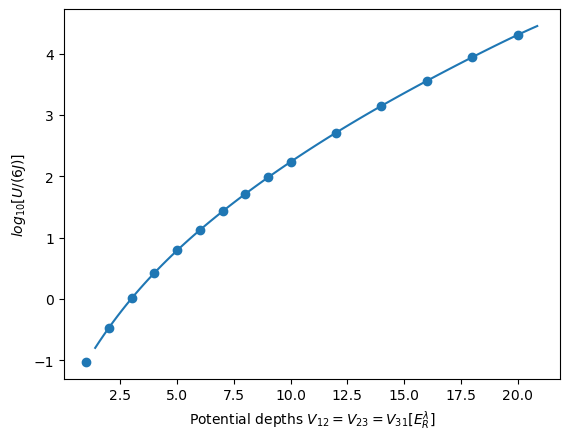

In [174]:
## Hubbard parameters for each potential depth
depth = np.array([1,2,3,4,5,6,7,8,9,10,12,14,16,18,20])
u_ov_6t = np.array([0.09423759108,0.3405272348,1.039420807,2.675594004,6.195279846,13.2800499,26.83593553,51.74380519,96.0052570,172.4697909,514.2282016,1408.480766,3606.249368,8736.47373,20204.02751])
z = np.polyfit(depth, np.log10(u_ov_6t), 7)
p = np.poly1d(z)
x_list = np.linspace(np.min(unique_param),np.max(unique_param),100)

plt.scatter(depth, np.log10(u_ov_6t))
plt.plot(x_list,p(x_list))
plt.xlabel(r'Potential depths $V_{12}=V_{23}=V_{31}[E_R^{\lambda}]$')
plt.ylabel(r'$log_{10}[U/(6J)]$')

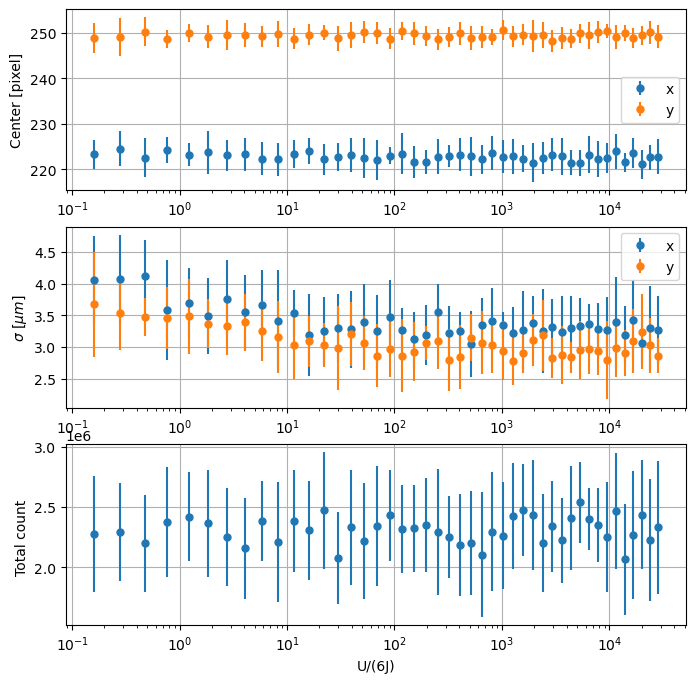

In [192]:
fig = plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(3,1,1)
ax1.errorbar(10**p(unique_param),cx_2_list,cx_2_err_list,fmt='o',markersize=5,label='x')
ax1.errorbar(10**p(unique_param),cy_2_list,cy_2_err_list,fmt='o',markersize=5,label='y')
ax1.set_ylabel("Center [pixel]")
ax1.set_xscale("log")
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(3,1,2)
ax2.errorbar(10**p(unique_param),np.array(sigx_2_list)*0.18782061063985978,np.array(sigx_2_err_list)*0.18782061063985978,fmt='o',markersize=5,label='x')
ax2.errorbar(10**p(unique_param),np.array(sigy_2_list)*0.18782061063985978,np.array(sigy_2_err_list)*0.18782061063985978,fmt='o',markersize=5,label='y')
ax2.set_ylabel(r"$\sigma$ [$\mu m$]")
ax2.set_xscale("log")
ax2.grid()
ax2.legend()

ax3 = fig.add_subplot(3,1,3)
ax3.errorbar(10**p(unique_param),total_count_list,total_count_err_list,fmt='o',markersize=5)
ax3.set_ylabel("Total count ")
ax3.set_xlabel(r"Potential depth [$E_R^{\lambda}$]")
ax3.set_xlabel(r"U/(6J)")
ax3.set_xscale("log")
ax3.grid()

In [193]:
import csv

outfile = open("SF_MI_center_width.csv","w",newline="")
writer = csv.writer(outfile)
writer.writerow(["Seq. No.", "Center X (px)", "Center Y (px)", "Sigma X (px)", "Sigma Y (px)"])

for i in range(len(trans_files)):
    writer.writerow([i, cx_list[i], cy_list[i], sigx_list[i], sigy_list[i]])

outfile.close()

In [194]:
csv_input = pd.read_csv("SF_MI_center_width.csv")